In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import joblib

from astropy.io import fits
from functools import reduce
from astropy.table import Table

sys.path.append('../../methods_code_Nresol/')
sys.path.append('../../utils/')
import astro_cuts
import importlib
import spec_utils

In [2]:
df_goodspec = pd.read_pickle('specmatched_northrerun.pkl')

In [3]:
len(df_goodspec)

210713

In [6]:
df_goodspec['chisq'] = df_goodspec['chisq_rerun']

## Section 1: 
### How many objects are not stars before cuts?

In [8]:
spec_utils.print_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'])

Number of Stars = 175597, Fraction(%) = 83.3347, Ratio(obj:star)*100 = 100
Number of Galaxies = 299, Fraction(%) = 0.1419, Ratio(obj:star)*100 = 0.1703
Number of QSOs = 34817, Fraction(%) = 16.5234, Ratio(obj:star)*100 = 19.8278


In [9]:
df_goodspec['sdss_dr17_specobj.CLASS'].unique()

array([b'QSO', b'STAR', b'GALAXY'], dtype=object)

In [10]:
galmask = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'GALAXY'
qsomask = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'QSO'

In [11]:
plt.rcParams.update({'font.family':'serif', 'font.size': 12})

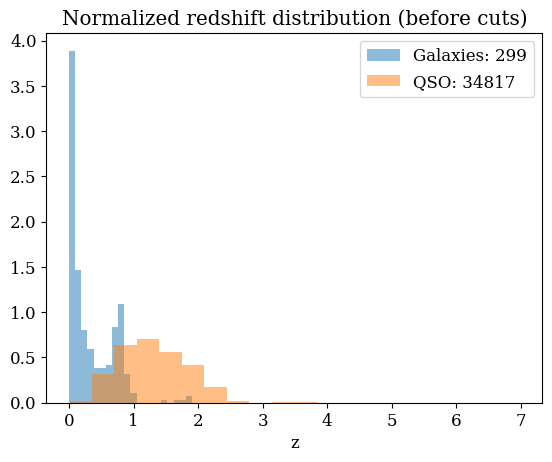

In [12]:
galz = df_goodspec.iloc[galmask, :]['sdss_dr17_specobj.Z']
quaz = df_goodspec.iloc[qsomask, :]['sdss_dr17_specobj.Z']
plt.figure()
plt.hist(galz, bins=20, label='Galaxies: {}'.format(np.sum(galmask)), alpha=0.5, density=True)
plt.hist(quaz, bins=20, label='QSO: {}'.format(np.sum(qsomask)), alpha=0.5, density=True)
plt.xlabel('z')
plt.legend()
plt.title('Normalized redshift distribution (before cuts)')
plt.savefig('../../plots/zdbn_before_rerun.pdf')
plt.show()

### After cuts: 16a

In [13]:
nbtest_dir = '../../notebooks_test/'

def combine_cuts(df_input, cuts_list):
    cutfuncs = [getattr(astro_cuts, ctup[0]) for ctup in cuts_list]
    masklist = []
    for c, ctup in enumerate(cuts_list):
        if len(ctup)==1:
            masklist.append(cutfuncs[c](df_input))
        else:
            masklist.append(cutfuncs[c](df_input, **ctup[1]))
        print('Cut{} {} {}'.format(c, np.sum(masklist[c]), np.sum(masklist[c])/len(masklist[c])))
    final_cut = reduce(np.logical_and, masklist) #intersection of all cuts
    print('Effective Cut = {:.3f}'.format(np.sum(final_cut)/len(final_cut)))
    return final_cut

In [15]:
wisemodel = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')
smodel = joblib.load('models/svm_sdss_quasarsep_balanced_new.joblib')

cuts_list = [('distmod_median_cut_corr', {'minpc': 400}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut_limiting', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]


final_cut = combine_cuts(df_goodspec, cuts_list) #intersection of all cuts
dfpost = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(dfpost['sdss_dr17_specobj.CLASS'])

Cut0 205550 0.9754974776117278
Cut1 200235 0.9502735948897315
Cut2 172977 0.8209128055696611
Cut3 210106 0.997119304456773
Cut4 173743 0.8245480819882969
Cut5 156011 0.740395704109381
Effective Cut = 0.659
Number of Stars = 138797, Fraction(%) = 99.9302, Ratio(obj:star)*100 = 100
Number of Galaxies = 51, Fraction(%) = 0.0367, Ratio(obj:star)*100 = 0.0367
Number of QSOs = 46, Fraction(%) = 0.0331, Ratio(obj:star)*100 = 0.0331


In [16]:
spec_utils.print_delta_obj_distribution(df_goodspec['sdss_dr17_specobj.CLASS'], dfpost['sdss_dr17_specobj.CLASS'])

StarFracChange = 16.595 (%)
GalFracChange = -0.105 (%)
QSOFracChange = -16.490 (%)
Stars thrown out = -36800


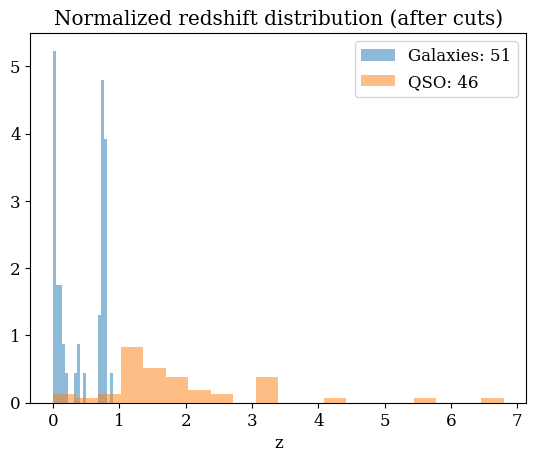

In [17]:
galmask = dfpost['sdss_dr17_specobj.CLASS'].to_numpy()==b'GALAXY'
qsomask = dfpost['sdss_dr17_specobj.CLASS'].to_numpy()==b'QSO'
galz = dfpost.iloc[galmask, :]['sdss_dr17_specobj.Z']
quaz = dfpost.iloc[qsomask, :]['sdss_dr17_specobj.Z']

plt.figure()
plt.hist(galz, bins=20, label='Galaxies: {}'.format(np.sum(galmask)), alpha=0.5, density=True)
plt.hist(quaz, bins=20, label='QSO: {}'.format(np.sum(qsomask)), alpha=0.5, density=True)
plt.xlabel('z')
plt.legend()
plt.title('Normalized redshift distribution (after cuts)')
plt.savefig('../../plots/zdbn_after_rerun.pdf')
plt.show()

#### Magnitude dbn

In [64]:
galmaskpre = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'GALAXY'
qsomaskpre = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'QSO'

In [65]:
exgalmaskpre = galmaskpre + qsomaskpre

In [62]:
exgalmask = galmask+qsomask

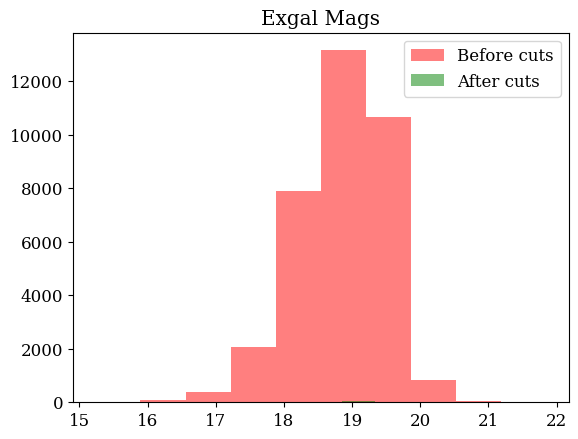

In [75]:
plt.figure()
plt.hist(df_goodspec.iloc[exgalmaskpre, :]['gaia_edr3.phot_g_mean_mag'].to_numpy(), color='r', bins=10, alpha=0.5, label='Before cuts')
plt.hist(df15k.iloc[exgalmask, :]['gaia_edr3.phot_g_mean_mag'].to_numpy(), color='g', bins=10, alpha=0.5, label='After cuts')
plt.legend()
plt.title('Exgal Mags')
plt.show()

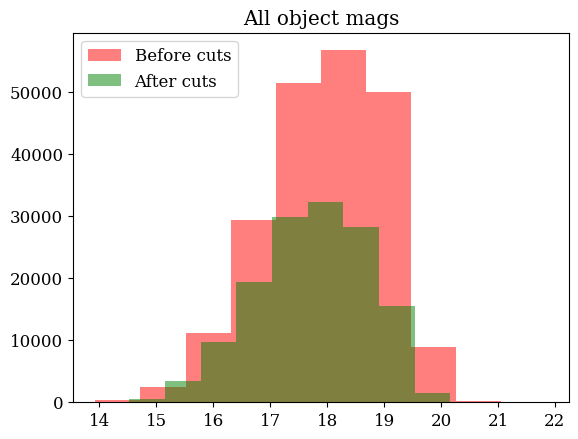

In [76]:
plt.figure()
plt.hist(df_goodspec['gaia_edr3.phot_g_mean_mag'].to_numpy(), color='r', bins=10, alpha=0.5, label='Before cuts')
plt.hist(df15k['gaia_edr3.phot_g_mean_mag'].to_numpy(), color='g', bins=10, alpha=0.5, label='After cuts')
plt.legend()
plt.title('All object mags')
plt.show()

### Pm/Par

In [8]:
galmask = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'GALAXY'
qsomask = df_goodspec['sdss_dr17_specobj.CLASS'].to_numpy()==b'QSO'
exgalmask = galmask + qsomask

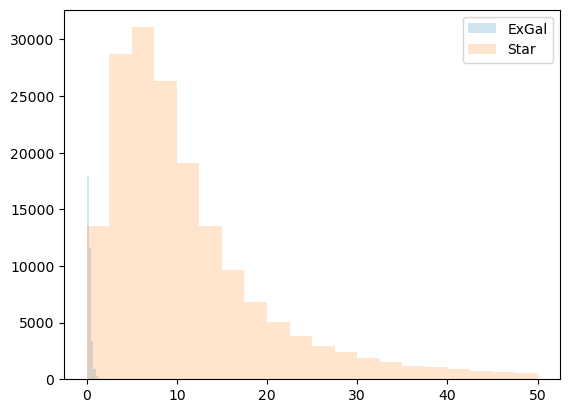

In [14]:
plt.figure()
plt.hist(df_goodspec.iloc[exgalmask, :]['gaia_edr3.pm'].to_numpy(), alpha=0.2, label='ExGal', bins=20, range=[0, 5])
plt.hist(df_goodspec.iloc[~exgalmask, :]['gaia_edr3.pm'].to_numpy(), alpha=0.2, label='Star', bins=20, range=[0, 50])
plt.legend()
plt.show()

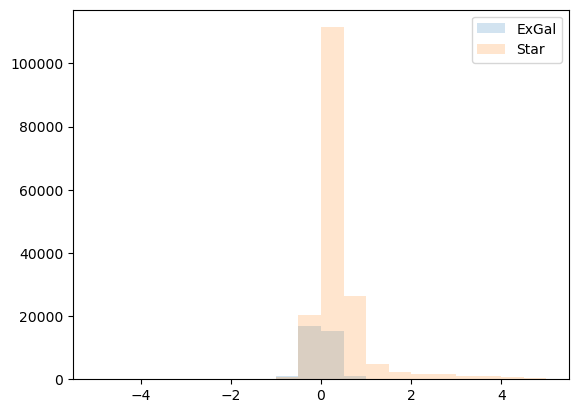

In [16]:
plt.figure()
plt.hist(df_goodspec.iloc[exgalmask, :]['gaia_edr3.parallax'].to_numpy(), alpha=0.2, label='ExGal', bins=20, range=[-5, 5])
plt.hist(df_goodspec.iloc[~exgalmask, :]['gaia_edr3.parallax'].to_numpy(), alpha=0.2, label='Star', bins=20, range=[-5, 5])
plt.legend()
plt.show()

In [17]:
import astro_cuts

In [46]:
allowed_exgal = astro_cuts.parallax_pm_combinedcut_and(df_goodspec.iloc[exgalmask, :], parsigthresh=1.0, pmsigthresh=1.0)

In [47]:
np.sum(allowed_exgal)/len(allowed_exgal)

0.3033944640619661

In [48]:
allowed_stars = astro_cuts.parallax_pm_combinedcut_and(df_goodspec.iloc[~exgalmask, :], parsigthresh=1.0, pmsigthresh=1.0)

In [49]:
np.sum(allowed_stars)/len(allowed_stars)

0.6771072398731186